
# 🧪 Top Quark **Tabular** — Streaming MLP (v6.1, leak‑safe holdout)

Validation scores looked "too perfect" because the validation sample was also seen during training.
This version **excludes** all selected validation rows from the streamed training passes (no leakage).
It keeps all v6 upgrades: streaming HDF5, auto label detection, wider MLP (GELU), ReduceLROnPlateau,
pos_weight, mixed precision, distributed validation, and threshold tuning.


In [1]:

import os, math, gc, random
from pathlib import Path
from typing import Optional, List, Tuple, Set

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, f1_score
from tqdm import tqdm

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [2]:

KEY         = "table"
CHUNK_SIZE  = 100_000
STATS_ROWS  = 200_000
BATCH_SIZE  = 4096
EPOCHS      = 8
LR          = 2e-3
ACCUM_STEPS = 1
MIXED_PREC  = (DEVICE.type == "cuda")
VAL_KEEP    = 20_000
EARLY_STOP  = True
PATIENCE    = 2

LABEL_COLS: Optional[List[str]] = None
ONE_HOT: Optional[bool] = None
MAX_TRAIN: Optional[int] = None
BASES = [Path("/kaggle/input"), Path("../input")]


In [3]:

CANDS = {"train": ["train.h5","train.hdf5"], "test": ["test.h5","test.hdf5"]}
found = {}
def _try_add(p: Path):
    if p.exists() and p.is_file(): found[p.name.lower()] = p
for base in BASES:
    if base.exists():
        for p in base.rglob("*.h5"):
            nm = p.name.lower()
            for lst in CANDS.values():
                if any(nm == c.lower() for c in lst): _try_add(p)

train_path = test_path = None
for nm, p in found.items():
    if "train.h5" in nm or "train.hdf5" in nm: train_path = p
    elif "test.h5" in nm or "test.hdf5" in nm: test_path = p

print("Discovered files:")
print("  train:", train_path)
print("  test :", test_path)
if train_path is None: raise SystemExit("❌ train.h5 not found.")


Discovered files:
  train: ../input/top-quark-tagging-reference/train.h5
  test : ../input/top-quark-tagging-reference/test.h5


In [4]:

def h5_row_count(path: Path, key: str) -> int:
    with pd.HDFStore(path, mode="r") as store:
        st = store.get_storer(key); return st.nrows

def read_h5_chunk(path: Path, key: str, start: int, stop: int, columns=None) -> pd.DataFrame:
    return pd.read_hdf(path, key=key, start=start, stop=stop, columns=columns)

def iterate_h5(path: Path, key: str, chunk_size: int, limit: Optional[int]=None):
    n = h5_row_count(path, key); 
    if limit is not None: n = min(n, limit)
    for start in range(0, n, chunk_size):
        stop = min(start + chunk_size, n); 
        yield start, stop, read_h5_chunk(path, key, start, stop)

def detect_label_columns(df: pd.DataFrame) -> Tuple[List[str], bool]:
    if LABEL_COLS is not None:
        cols = LABEL_COLS
        is_one_hot = ONE_HOT if ONE_HOT is not None else (len(cols) >= 2)
        return cols, is_one_hot
    int_like = []; bin_like = []
    for c in df.columns:
        s = df[c]
        if pd.api.types.is_bool_dtype(s) or pd.api.types.is_integer_dtype(s):
            if s.nunique(dropna=True) <= 3: int_like.append(c)
        elif pd.api.types.is_float_dtype(s):
            uv = pd.unique(s.dropna())
            if len(uv) <= 3 and np.isin(uv, [0.0,1.0]).all(): bin_like.append(c)
    cand = int_like + bin_like
    if len(cand) >= 2: return cand[:2], True
    if len(cand) >= 1: return [cand[0]], False
    tail = df.columns[-2:]
    ok = all(df[c].nunique(dropna=True) <= 10 for c in tail)
    if ok: return list(tail), True
    raise RuntimeError("Could not auto-detect label columns. Set LABEL_COLS manually.")

def split_features_labels(df: pd.DataFrame, label_cols: List[str], one_hot: bool):
    if one_hot and len(label_cols) >= 2:
        y_oh = df[label_cols].values
        y = np.argmax(y_oh, axis=1).astype(np.int64)
        X = df.drop(columns=label_cols)
    else:
        y = df[label_cols[0]].astype(int).values
        X = df.drop(columns=label_cols)
    X = X.select_dtypes(include=[np.number]).astype(np.float32)
    return X.values, y

class SampleStandardizer:
    def __init__(self): self.mean_=None; self.std_=None
    def fit_sample_spread(self, path: Path, key: str, sample_rows: int, chunk_size: int, limit: Optional[int]=None, parts: int=5):
        n = h5_row_count(path, key); 
        if limit is not None: n = min(n, limit)
        per_part = max(sample_rows // parts, min(chunk_size, n))
        total = 0; sums=None; sqrs=None; nfeat=None
        for k in range(parts):
            start = int(k * (n-1) / max(parts-1,1)); stop = min(start + per_part, n)
            if stop<=start: continue
            df = read_h5_chunk(path, key, start, stop)
            labs, oh = detect_label_columns(df)
            X,_ = split_features_labels(df, labs, oh)
            if nfeat is None:
                nfeat = X.shape[1]; sums = np.zeros(nfeat); sqrs = np.zeros(nfeat)
            m = X.mean(0); v = X.var(0); cnt = X.shape[0]
            sums += m*cnt; sqrs += (v+m**2)*cnt; total += cnt
            del df, X; gc.collect()
            if total >= sample_rows: break
        total = max(total,1)
        self.mean_ = (sums/total).astype(np.float32)
        self.std_  = np.sqrt(np.maximum(sqrs/total - self.mean_**2, 1e-8)).astype(np.float32)
    def transform(self, X: np.ndarray): 
        if self.mean_ is None: return X
        return (X - self.mean_) / (self.std_ + 1e-6)

def estimate_pos_weight_spread(path: Path, key: str, label_cols: List[str], one_hot: bool, sample_rows=50_000, parts=5):
    n = h5_row_count(path, key); step = max(n//parts,1)
    seen_pos=0; seen_tot=0; per=sample_rows//parts
    for k in range(parts):
        start = k*step; stop = min(start+per, n)
        if stop<=start: continue
        df = read_h5_chunk(path, key, start, stop)
        _, y = split_features_labels(df, label_cols, one_hot)
        y = y.reshape(-1)
        seen_pos += int((y==1).sum()); seen_tot += y.size
        del df, y; gc.collect()
    pos=max(seen_pos,1); neg=max(seen_tot-seen_pos,1)
    return neg/pos


In [5]:

class MLP(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.BatchNorm1d(1024), nn.GELU(), nn.Dropout(0.30),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512), nn.GELU(), nn.Dropout(0.25),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256), nn.GELU(), nn.Dropout(0.20),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.net(x).squeeze(1)

@torch.no_grad()
def evaluate_auc(model, loader, mixed=True):
    model.eval()
    ys, ps = [], []
    for xb, yb in loader:
        xb = xb.float().to(DEVICE, non_blocking=True)
        with torch.amp.autocast('cuda', enabled=(mixed and DEVICE.type=='cuda')):
            logits = model(xb)
        prob = torch.sigmoid(logits).detach().cpu().numpy()
        ps.append(prob); ys.append(yb.numpy())
    y = np.concatenate(ys, 0); p = np.concatenate(ps, 0)
    try: auc = roc_auc_score(y, p)
    except Exception: auc = float("nan")
    return y, p, auc


Fitting feature scaler (spread)...
Scaler ready.
Detected label columns: ['ttv', 'is_signal_new'] one_hot: True
Holdout rows: 13000 / 1211000


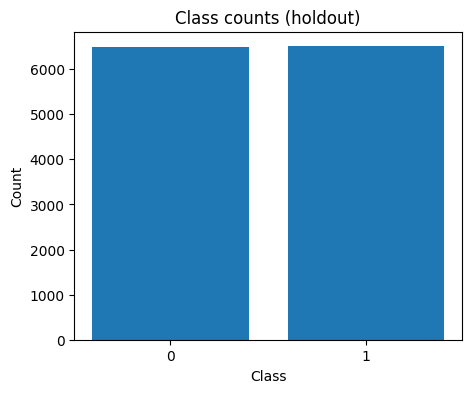

Estimated pos_weight: 1.042483660130719
[01/8] loss=0.0471  val_auc=0.9997
[02/8] loss=0.0109  val_auc=0.9966
[03/8] loss=0.0111  val_auc=0.9311
Early stopping.


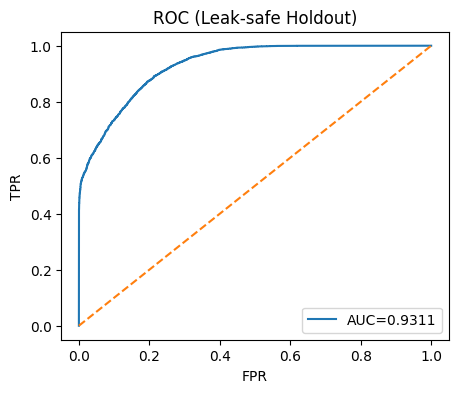

Best threshold by Youden's J: 0.0600
Best threshold by F1       : 0.0500 (F1=0.8446)

Confusion Matrix @ J-opt threshold (0.0600):
[[5234 1263]
 [ 833 5670]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8627    0.8056    0.8332      6497
         1.0     0.8178    0.8719    0.8440      6503

    accuracy                         0.8388     13000
   macro avg     0.8403    0.8388    0.8386     13000
weighted avg     0.8403    0.8388    0.8386     13000


Confusion Matrix @ F1-opt threshold (0.0500):
[[5132 1365]
 [ 751 5752]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8723    0.7899    0.8291      6497
         1.0     0.8082    0.8845    0.8446      6503

    accuracy                         0.8372     13000
   macro avg     0.8403    0.8372    0.8369     13000
weighted avg     0.8403    0.8372    0.8369     13000



In [6]:

print("Fitting feature scaler (spread)...")
scaler = SampleStandardizer()
scaler.fit_sample_spread(train_path, KEY, sample_rows=STATS_ROWS, chunk_size=CHUNK_SIZE, limit=MAX_TRAIN, parts=5)
print("Scaler ready.")

# Detect labels & input dim
_, _, df0 = next(iterate_h5(train_path, KEY, chunk_size=min(10_000, CHUNK_SIZE), limit=MAX_TRAIN))
label_cols, one_hot = detect_label_columns(df0)
print("Detected label columns:", label_cols, "one_hot:", one_hot)
X0, y0 = split_features_labels(df0, label_cols, one_hot)
in_features = X0.shape[1]

# Distributed holdout (record global indices)
print("Collecting distributed holdout & marking exclusion...")
holdout_idx: Set[int] = set()
Xv_list, yv_list = [], []
taken = 0
n_total = h5_row_count(train_path, KEY) if MAX_TRAIN is None else min(h5_row_count(train_path, KEY), MAX_TRAIN)
for start, stop, df in iterate_h5(train_path, KEY, CHUNK_SIZE, limit=MAX_TRAIN):
    X, y = split_features_labels(df, label_cols, one_hot)
    m = min(1000, X.shape[0])
    if m > 0:
        idx_local = np.linspace(0, X.shape[0]-1, num=m, dtype=int)
        Xv_list.append(X[idx_local]); yv_list.append(y[idx_local])
        gidx = start + idx_local
        holdout_idx.update(int(i) for i in gidx)
        taken += m
        if taken >= VAL_KEEP: break
Xv = np.concatenate(Xv_list, 0) if Xv_list else None
yv = np.concatenate(yv_list, 0) if yv_list else None
print(f"Holdout rows: {len(holdout_idx)} / {n_total}")

if yv is not None:
    unique, counts = np.unique(yv, return_counts=True)
    plt.figure(figsize=(5,4))
    plt.bar([str(u) for u in unique], counts)
    plt.title("Class counts (holdout)")
    plt.xlabel("Class"); plt.ylabel("Count")
    plt.show()

pos_w_value = estimate_pos_weight_spread(train_path, KEY, label_cols, one_hot, sample_rows=min(50_000, STATS_ROWS//2), parts=5)
print("Estimated pos_weight:", pos_w_value)

model = MLP(in_features).to(DEVICE)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=1)
scaler_amp = torch.amp.GradScaler('cuda', enabled=MIXED_PREC)
pos_w_tensor = torch.tensor([pos_w_value], dtype=torch.float32, device=DEVICE)

vloader = None
if Xv is not None:
    Xv_s = scaler.transform(Xv).astype(np.float32)
    vloader = DataLoader(TensorDataset(torch.from_numpy(Xv_s), torch.from_numpy(yv.astype(np.float32))),
                         batch_size=4096, shuffle=False, num_workers=0)

best_auc = -1.0; epochs_no_improve = 0
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss, n_obs = 0.0, 0
    for start, stop, df in iterate_h5(train_path, KEY, CHUNK_SIZE, limit=MAX_TRAIN):
        X, y = split_features_labels(df, label_cols, one_hot)
        # exclude holdout rows for this chunk
        if holdout_idx:
            local = [i - start for i in holdout_idx if start <= i < stop]
            if local:
                mask = np.ones(X.shape[0], dtype=bool)
                mask[np.array(local, dtype=int)] = False
                X = X[mask]; y = y[mask]
                if X.shape[0] == 0:
                    del df; gc.collect(); continue

        X = scaler.transform(X).astype(np.float32)
        y = y.astype(np.float32)

        ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

        opt.zero_grad(set_to_none=True)
        for i, (xb, yb) in enumerate(loader):
            xb = xb.float().to(DEVICE, non_blocking=True)
            yb = yb.float().to(DEVICE, non_blocking=True)
            with torch.amp.autocast('cuda', enabled=MIXED_PREC):
                logits = model(xb)
                loss = F.binary_cross_entropy_with_logits(logits, yb, pos_weight=pos_w_tensor) / ACCUM_STEPS
            scaler_amp.scale(loss).backward()
            if (i+1) % ACCUM_STEPS == 0:
                scaler_amp.step(opt); scaler_amp.update(); opt.zero_grad(set_to_none=True)
            total_loss += loss.item() * xb.size(0) * ACCUM_STEPS
            n_obs += xb.size(0)

        del X, y, ds, loader, df
        gc.collect()

    if vloader is not None:
        y_true, y_prob, auc = evaluate_auc(model, vloader, mixed=MIXED_PREC)
    else:
        auc = float("nan")
    print(f"[{epoch:02d}/{EPOCHS}] loss={total_loss/max(n_obs,1):.4f}  val_auc={auc:.4f}")

    if not math.isnan(auc):
        scheduler.step(auc)
        if auc > best_auc + 1e-5:
            best_auc = auc; epochs_no_improve = 0
            Path("./outputs").mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), "./outputs/best_model.pt")
        else:
            epochs_no_improve += 1
            if EARLY_STOP and epochs_no_improve >= PATIENCE:
                print("Early stopping."); break

# Validation ROC + thresholds
if vloader is not None:
    y_true, y_prob, auc = evaluate_auc(model, vloader, mixed=MIXED_PREC)
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Leak‑safe Holdout)"); plt.legend()
    plt.show()

    j = tpr - fpr; best_idx = np.argmax(j); thr_j = thr[best_idx]
    grid = np.linspace(0.05, 0.95, 19)
    f1s = [f1_score(y_true, (y_prob >= t).astype(int)) for t in grid]
    thr_f1 = float(grid[int(np.argmax(f1s))])

    print(f"Best threshold by Youden's J: {thr_j:.4f}")
    print(f"Best threshold by F1       : {thr_f1:.4f} (F1={max(f1s):.4f})")

    for name, T in [("J", thr_j), ("F1", thr_f1)]:
        y_pred = (y_prob >= T).astype(int)
        print(f"\nConfusion Matrix @ {name}-opt threshold ({T:.4f}):")
        print(confusion_matrix(y_true, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=4))


In [7]:

# Test-time probabilities
if test_path is not None:
    preds = []; ids = []; row0 = 0
    for start, stop, df in iterate_h5(test_path, KEY, CHUNK_SIZE, limit=None):
        try:
            X, _ = split_features_labels(df, label_cols, one_hot)
        except Exception:
            X = df.select_dtypes(include=[np.number]).values.astype(np.float32)
        X = scaler.transform(X).astype(np.float32)
        with torch.no_grad(), torch.amp.autocast('cuda', enabled=MIXED_PREC):
            xb = torch.from_numpy(X).float().to(DEVICE, non_blocking=True)
            prob = torch.sigmoid(model(xb)).cpu().numpy()
        preds.append(prob.reshape(-1))
        ids.append(np.arange(row0, row0 + X.shape[0]))
        row0 += X.shape[0]
        del df, X, xb, prob
        gc.collect()

    prob = np.concatenate(preds, 0)
    jet_id = np.concatenate(ids, 0)
    sub = pd.DataFrame({"jet_id": jet_id, "prob_top": prob})
    out_csv = Path("./outputs/submission.csv")
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    sub.to_csv(out_csv, index=False)
    print("Wrote:", out_csv)


Wrote: outputs/submission.csv
